# Overview of the SCENIC+ result

In [1]:
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
root_dir = "/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/"
os.chdir(Path(root_dir) / "scenicplus" / "all")

In [3]:
import mudata
scplus_mdata = mudata.read("scplus_outputs/scplusmdata.h5mu")

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be remo

In [4]:
scplus_mdata

MuData object with n_obs × n_vars = 113924 × 585975
  uns:	'direct_e_regulon_metadata', 'extended_e_regulon_metadata'
  6 modalities
    scRNA_counts:	113924 x 32876
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Batch', 'percent.mt', 'Major_Class', 'PatientID', 'Region', 'Subclass_F', 'Cell_type'
      obsm:	'X_pca', 'X_umap'
    scATAC_counts:	113924 x 552209
      obs:	'cisTopic_nr_frag', 'cisTopic_log_nr_acc', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Batch', 'percent.mt', 'Major_Class', 'PatientID', 'Region', 'Subclass_F', 'Cell_type', 'sample_id', 'BICCN_5K_leiden_10_0.2', 'BICCN_5K_leiden_10_0.4'
      var:	'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
      obsm:	'UMAP'
    direct_gene_based_AUC:	113924 x 270
    direct_region_based_AUC:	113924 x 270
    extended_gene_based_AUC:	113924 x 175
    extended_region_based_AUC:	113924 x 175

## Cluster

In [5]:
import scanpy as sc
import anndata
eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["direct_region_based_AUC"]],
    axis=1,
)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


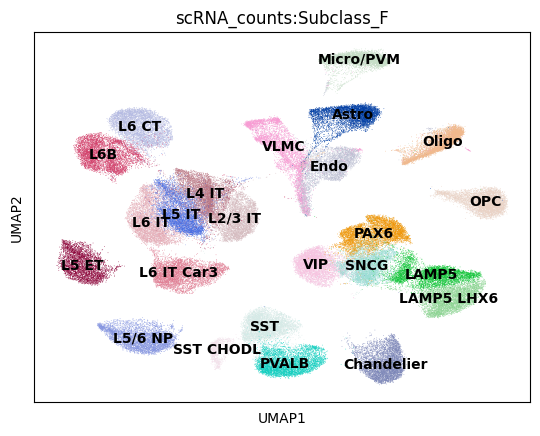

In [6]:
eRegulon_gene_AUC.obs = scplus_mdata.obs.loc[eRegulon_gene_AUC.obs_names]
sc.pp.neighbors(eRegulon_gene_AUC, use_rep = "X")
sc.tl.umap(eRegulon_gene_AUC)
sc.pl.umap(eRegulon_gene_AUC, color = "scRNA_counts:Subclass_F", legend_loc="on data")

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


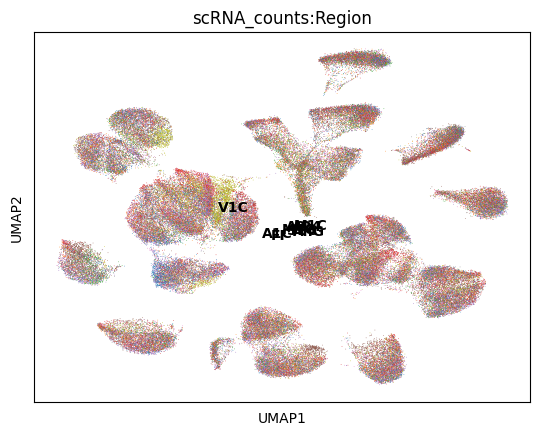

In [7]:
sc.pl.umap(eRegulon_gene_AUC, color = "scRNA_counts:Region", legend_loc="on data")

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


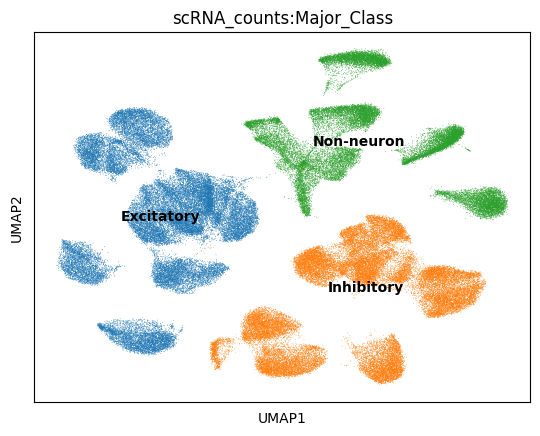

In [8]:
sc.pl.umap(eRegulon_gene_AUC, color = "scRNA_counts:Major_Class", legend_loc="on data")

## Specificy score analysis

In [5]:
from scenicplus.RSS import (regulon_specificity_scores, plot_rss)

In [6]:
rss = regulon_specificity_scores(
    scplus_mudata=scplus_mdata,
    variable="scRNA_counts:Subclass_F",
    modalities=["direct_gene_based_AUC"]
)

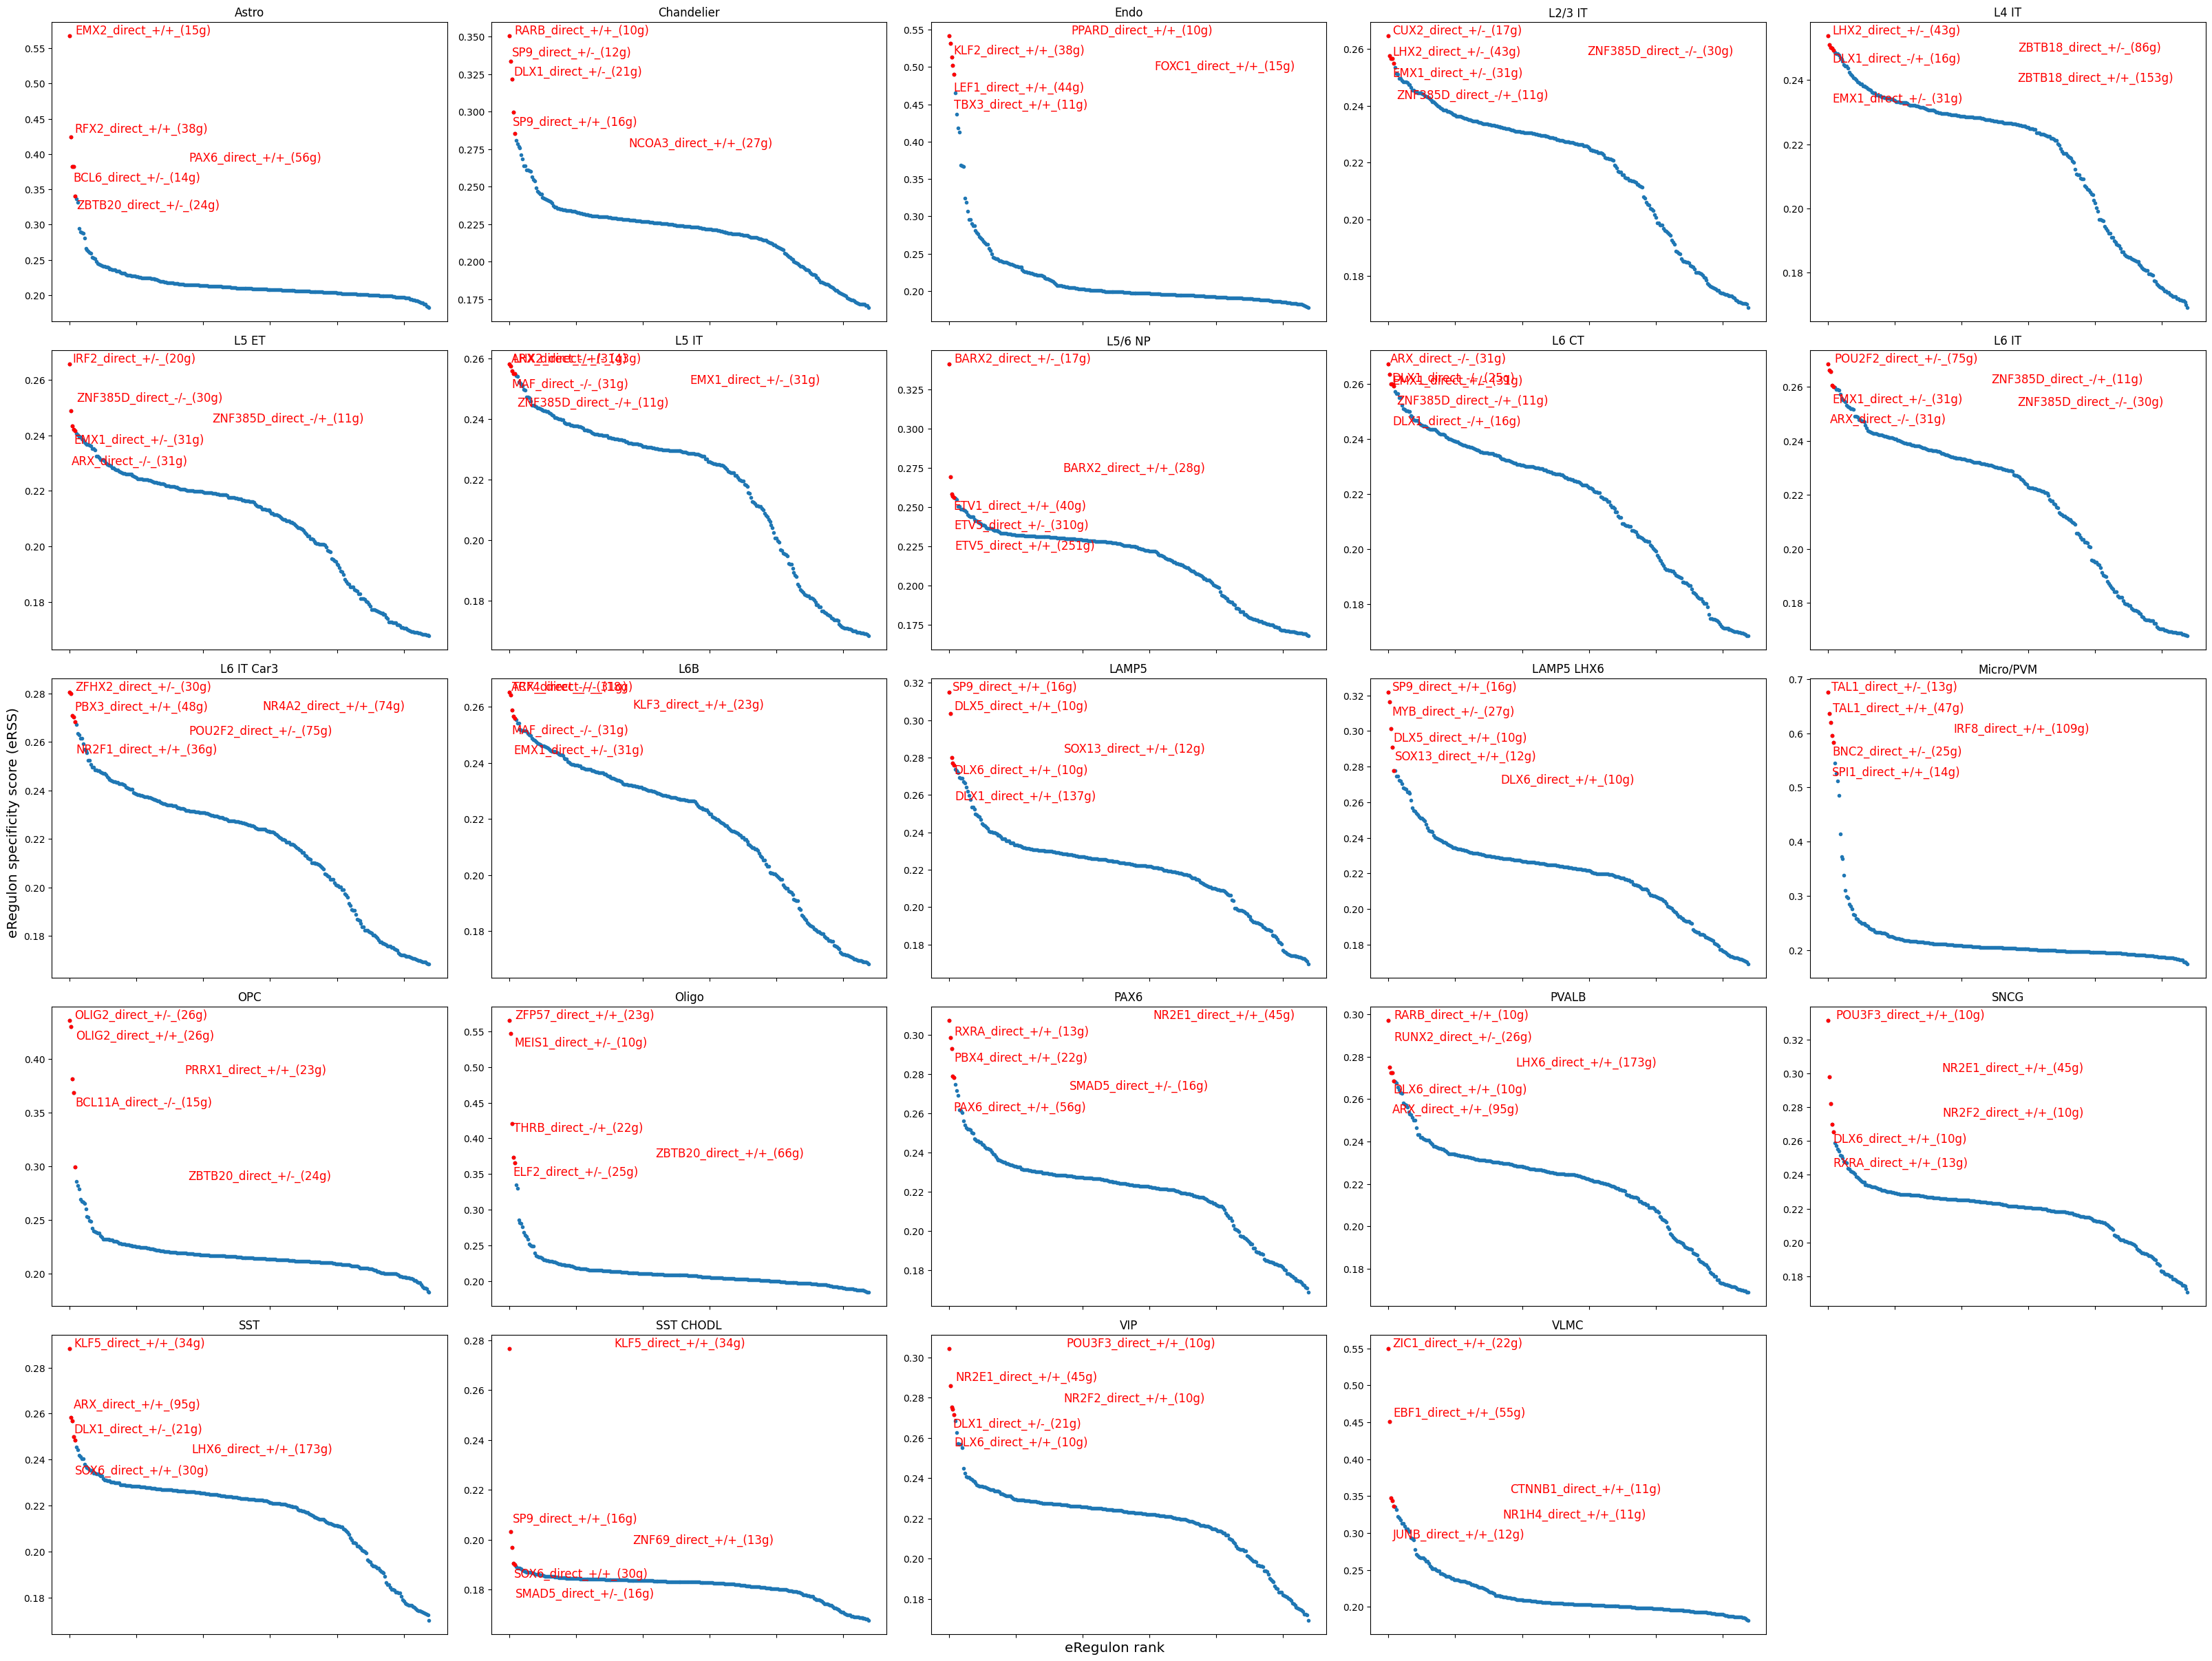

In [7]:
plot_rss(data_matrix=rss, top_n=5, num_columns=5)

In [8]:
cluster_order = [
    "L2/3 IT", "L4 IT", "L5 IT", "L6 IT", "L5/6 NP", "L6 CT", "L6B", "L6 IT Car3", "L5 ET",
    "PVALB", "SST", "SST CHODL", "Chandelier", "PAX6", "VIP", "SNCG", "LAMP5", "LAMP5 LHX6",
    "Oligo", "Astro", "Micro/PVM", "OPC", "Endo", "VLMC"
]

In [9]:
import numpy as np
plot_matrix = rss.loc[cluster_order, :].copy()
plot_matrix_z = plot_matrix.sub(plot_matrix.mean(axis=1), axis=0).div(plot_matrix.std(axis=1, ddof=0), axis=0)
# very interesting approach
sorted_indices = np.argsort(plot_matrix_z.values.argmax(axis=0))
plot_final = plot_matrix_z.iloc[:, sorted_indices].T.copy()

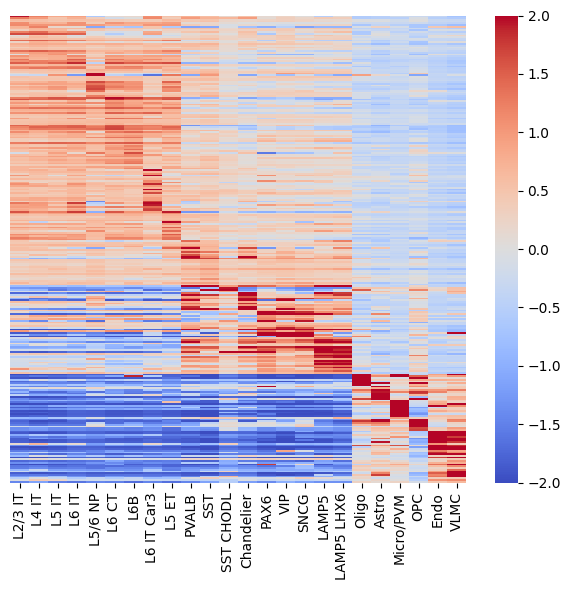

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    plot_final,
    vmin=-2,
    vmax=2,
    cmap="coolwarm",
    center=0,
    yticklabels=[],
    ax=ax
)
figure_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/final_figures/")
fig.savefig(figure_dir / "specificty_scores.pdf", format="pdf")

In [4]:
direct_regulons = pd.read_csv("scplus_outputs/eRegulon_direct.tsv", sep="\t", header=0)
extend_regulons = pd.read_csv("scplus_outputs/eRegulons_extended.tsv", sep="\t", header=0)

In [18]:
direct_regulons[direct_regulons["Gene_signature_name"] == "RUNX1_direct_+/+_(81g)"]["Gene"].unique().tolist()

['CSF3R',
 'CYBA',
 'LAIR1',
 'CYTH4',
 'C1QC',
 'BNC2',
 'CLEC9A',
 'SYNDIG1',
 'CSF2RA',
 'SIRPB2',
 'IFNGR1',
 'FYB1',
 'WDFY4',
 'LY86',
 'P2RY13',
 'PADI2',
 'IRF8',
 'ITGAM',
 'KLHL6',
 'DOCK2',
 'HLA-DRB1',
 'ADAM28',
 'ZNF710',
 'ACY3',
 'PIK3R5',
 'P2RY12',
 'CH25H',
 'LPAR5',
 'S100Z',
 'SELPLG',
 'SIGLEC10',
 'CLEC7A',
 'PALD1',
 'BIN2',
 'SAMSN1',
 'VAV1',
 'LRMDA',
 'IL18',
 'TREM2',
 'C1QA',
 'HLA-DRA',
 'OTULINL',
 'C1QB',
 'ARRDC5',
 'ELF1',
 'LPAR6',
 'IKZF1',
 'LAPTM5',
 'FAM149A',
 'ITGAX',
 'LILRB1',
 'PRAM1',
 'FCGR1A',
 'OLR1',
 'MYO1F',
 'SUSD3',
 'HLA-DMB',
 'CASS4',
 'PTPRC',
 'CD84',
 'UHRF1',
 'TFEC',
 'LILRB4',
 'ITGB2',
 'CYBB',
 'STAB1',
 'ENTPD1',
 'TGFB1',
 'PIK3AP1',
 'TLR2',
 'RHBDF2',
 'CMTM7',
 'MMRN1',
 'ATP8B4',
 'PARVG',
 'ABCC4',
 'FGD3',
 'GPR34',
 'ALOX5',
 'TRIM38',
 'MS4A7']

In [3]:
direct_regulons = pd.read_csv("scplus_outputs/eRegulon_direct.tsv", sep="\t", header=0)
extend_regulons = pd.read_csv("scplus_outputs/eRegulons_extended.tsv", sep="\t", header=0)
tf_orders = [xx.split("_")[0] for xx in plot_final.index.to_list()]

NameError: name 'plot_final' is not defined

In [14]:
## First create heatmaps of tf corr scores along RC axis
nrow = len(tf_orders)
ncol = len(cluster_order)
tf_rc_corrs = np.zeros((nrow, ncol))
tf_rc_ps = np.zeros((nrow, ncol))

for j, cluster in enumerate(cluster_order):
    cluster_name = cluster.replace("/", "_").replace(" ", "_")
    if cluster_name == "Micro_PVM":
        cluster_name = "Micro"
    j_df = pd.read_csv(
        f"../other_celltypes/corr_genes_7e-1_1e-2_expr_filtered/{cluster_name}_RC_table.tsv", 
        sep="\t", header=0, index_col=0
    )
    j_genes = set(j_df.index.to_list())
    for i, tf in enumerate(tf_orders):
        if tf in j_genes:
            tf_rc_corrs[i, j] = j_df.loc[tf, "corr"]
            tf_rc_ps[i, j] = j_df.loc[tf, "p_adjusted"]

In [20]:
corr_cutoffs = np.abs(tf_rc_corrs) > 0.5
p_cutoffs = tf_rc_ps < 0.01
plot_matrix = tf_rc_corrs * p_cutoffs * corr_cutoffs

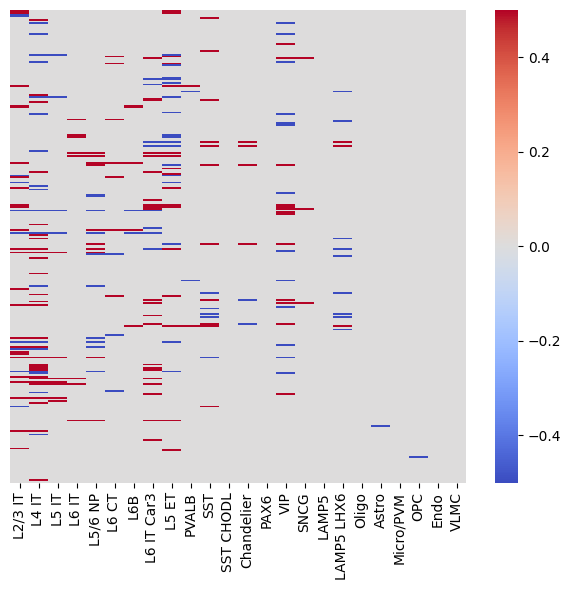

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    plot_matrix,
    vmin=-0.5,
    vmax=0.5,
    center=0,
    cmap="coolwarm",
    yticklabels=[],
    xticklabels=cluster_order,
    ax=ax
)
figure_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/final_figures/")
fig.savefig(figure_dir / "specificty_scores_rc_rna.pdf", format="pdf")

In [46]:
## First create heatmaps of tf corr scores along RC axis
tf_orders = plot_final.index.to_list()
nrow = len(tf_orders)
ncol = len(cluster_order)
tf_rc_atac_corrs = np.zeros((nrow, ncol))

for j, cluster in enumerate(cluster_order):
    cluster_name = cluster.replace("/", "_").replace(" ", "_")
    if cluster_name == "Micro_PVM":
        cluster_name = "Micro"
    if cluster_name == "SST_CHODL":
        continue
    j_df = pd.read_csv(
        f"../other_celltypes/corr_regions_5e-1_5e-2_expr_filtered/{cluster_name}_RC_table.tsv", 
        sep="\t", header=0, index_col=0
    )
    # j_df_filtered = j_df[j_df["p_adjusted"] < 0.05]
    j_regions = set(j_df.index.to_list())
    for i, tf in enumerate(tf_orders):
        unfiltered_regions = direct_regulons[direct_regulons["Gene_signature_name"] == tf]["Region"].to_list()
        unfiltered_regions = [xx.replace(":", "-") for xx in unfiltered_regions]
        filtered_regions = [xx for xx in unfiltered_regions if xx in j_regions]
        if len(filtered_regions) > 0:
            tf_rc_atac_corrs[i, j] = np.mean(j_df.loc[filtered_regions, "corr"])

In [47]:
corr_cutoffs = np.abs(tf_rc_atac_corrs) > 0.15
plot_matrix = tf_rc_atac_corrs * corr_cutoffs

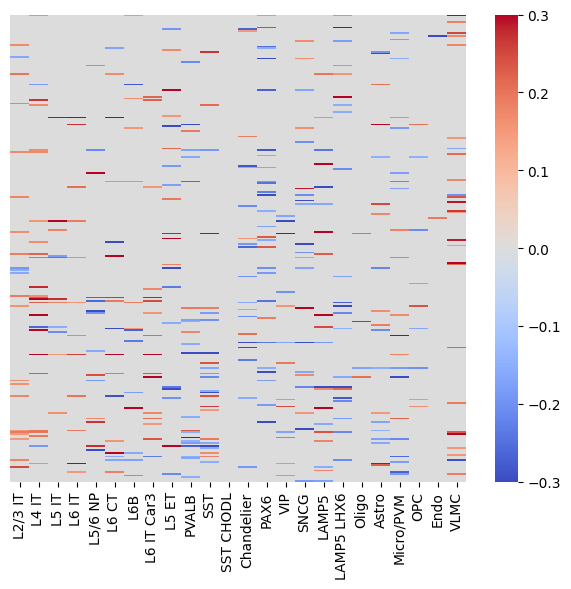

In [50]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    plot_matrix,
    vmin=-0.3,
    vmax=0.3,
    center=0,
    cmap="coolwarm",
    yticklabels=[],
    xticklabels=cluster_order,
    ax=ax
)
figure_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/final_figures/")
fig.savefig(figure_dir / "specificty_scores_rc_atac_version2.pdf", format="pdf")

In [44]:
file_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/final_files/")
plot_final.to_csv(file_dir / "specificity_score_z.tsv", sep="\t", header=True, index=True)
np.savetxt(str(file_dir / "specificity_tf_rna.tsv"), tf_rc_corrs, delimiter="\t")
np.savetxt(str(file_dir / "specificity_tf_atac.tsv"), tf_rc_atac_corrs, delimiter="\t")
np.savetxt(str(file_dir / "specificity_tf_rna_pvalues.tsv"), tf_rc_ps, delimiter="\t")

## Rank DARs and their predicted target genes

In [3]:
import scanpy as sc
import decoupler as dc
import re
import numpy as np
from scipy.stats import zscore

In [4]:
## Read in RNA and ATAC dataset
BICCN_rna = sc.read_h5ad("BICCN_5K_rna.h5ad")
BICCN_rna = BICCN_rna.raw.to_adata()

In [5]:
BICCN_atac_matrix = sc.read_mtx("BICCN_5K_atac.mtx")
BICCN_atac = BICCN_atac_matrix.T
BICCN_atac.obs_names = BICCN_rna.obs_names
region_names = pd.read_csv("BICCN_5K_region.tsv", header=None, index_col=0, sep="\t")
region_names.index.name = None
BICCN_atac.var = region_names
BICCN_atac.write_h5ad("BICCN_5K_atac.h5ad")

In [6]:
## Read in regulon information
direct_regulon_meta = pd.read_csv(
    "scplus_outputs/eRegulon_direct.tsv", header=0, sep="\t")

In [7]:
positive_regulon_meta = direct_regulon_meta[direct_regulon_meta.apply(
    lambda row: row["eRegulon_name"].endswith("+"), axis=1)]

In [8]:
class_order = [
    "L2_3_IT", "L4_IT", "L5_IT", "L6_IT", "L6_IT_Car3",
    "L5_ET", "L5_6_NP", "L6B", "L6_CT", "LAMP5_LHX6",
    "LAMP5", "SNCG", "VIP", "PAX6", "Chandelier",
    "PVALB", "SST", "SST_CHODL", "Astro", "Micro_PVM",
    "OPC", "Oligo", "Endo", "VLMC"
]

In [9]:
## What does this pipeline find?

In [10]:
BICCN_atac.obs = BICCN_rna.obs.copy()

In [11]:
curr_rna_agg = dc.get_pseudobulk(
    adata=BICCN_rna,
    sample_col="Subclass_F",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=False,
    mode="sum"
)

In [14]:
sc.pp.normalize_total(curr_rna_agg, target_sum=1e6)
sc.pp.log1p(curr_rna_agg, base=2)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [28]:
BICCN_gene_expr_df = pd.DataFrame(
    curr_rna_agg.X.T, 
    columns=[re.sub(f"[ /]", "_", xx) for xx in curr_rna_agg.obs_names.to_list()],
    index=curr_rna_agg.var_names
)
BICCN_gene_expr_df = BICCN_gene_expr_df.loc[:, class_order]

In [29]:
BICCN_gene_expr_df = BICCN_gene_expr_df.apply(zscore, axis=1)

In [30]:
curr_atac_agg = dc.get_pseudobulk(
    adata=BICCN_atac,
    sample_col="Subclass_F",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=False,
    mode="sum"
)

In [31]:
sc.pp.normalize_total(curr_atac_agg, target_sum=1e6)
sc.pp.log1p(curr_atac_agg, base=2)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [34]:
BICCN_atac_cov_df = pd.DataFrame(
    curr_atac_agg.X.T, 
    columns=[re.sub(f"[ /]", "_", xx) for xx in curr_atac_agg.obs_names.to_list()],
    index=curr_atac_agg.var_names
)
BICCN_atac_cov_df = BICCN_atac_cov_df.loc[:, class_order]

In [44]:
BICCN_marker_atac_cov = dict()
for subclass in BICCN_atac_cov_df.columns:
    print(f"Processing {subclass}...")
    curr_atac_cov = BICCN_atac_cov_df.loc[:, [subclass]]
    
    curr_marker_bed = pd.read_csv(
        str(Path("region_sets/") / "DARs_subclass" / f"{subclass}.bed"),
        index_col=None, header=None, sep="\t")
    curr_marker_bed.columns = ["chr", "start", "end"]
    curr_markers = curr_marker_bed.apply(
        lambda row: "-".join([row["chr"], str(row["start"]), str(row["end"])]), axis=1).to_list()
    curr_atac_cov = curr_atac_cov.loc[curr_markers, :]
    
    BICCN_marker_atac_cov[subclass] = curr_atac_cov

Processing L2_3_IT...
Processing L4_IT...
Processing L5_IT...
Processing L6_IT...
Processing L6_IT_Car3...
Processing L5_ET...
Processing L5_6_NP...
Processing L6B...
Processing L6_CT...
Processing LAMP5_LHX6...
Processing LAMP5...
Processing SNCG...
Processing VIP...
Processing PAX6...
Processing Chandelier...
Processing PVALB...
Processing SST...
Processing SST_CHODL...
Processing Astro...
Processing Micro_PVM...
Processing OPC...
Processing Oligo...
Processing Endo...
Processing VLMC...


In [45]:
for key in BICCN_marker_atac_cov:
    BICCN_marker_atac_cov[key].columns = [key]
BICCN_marker_atac_cov_df = pd.concat(BICCN_marker_atac_cov.values(), axis=1)
BICCN_marker_atac_cov_df.fillna(value=0, inplace=True)
BICCN_marker_atac_cov_df = BICCN_marker_atac_cov_df.apply(zscore, axis=1)
sort_values = BICCN_marker_atac_cov_df.apply(lambda row: row.max(), axis=1)
sort_class = BICCN_marker_atac_cov_df.apply(lambda row: BICCN_marker_atac_cov_df.columns[row.argmax()], axis=1)
sort_table = pd.DataFrame({"class": sort_class, "value": sort_values})
sort_table["class"] = pd.Categorical(
    sort_table["class"], categories=class_order, ordered=True)
sort_table["barcode"] = sort_table.index
sort_table = sort_table.groupby("class").apply(
    lambda x: x.sort_values("value", ascending=False)).reset_index(drop=True)
sort_table["barcode_variant"] = sort_table.apply(lambda row: "{}:{}-{}".format(*row["barcode"].split("-")), axis=1)

In [46]:
mask = positive_regulon_meta[positive_regulon_meta["Region"].isin(sort_table["barcode_variant"])]
BICCN_marker_gene_df = pd.merge(sort_table, mask, right_on="Region", left_on="barcode_variant", how="inner")
BICCN_marker_gene_df = BICCN_marker_gene_df.drop_duplicates(subset=["Region", "Gene"])

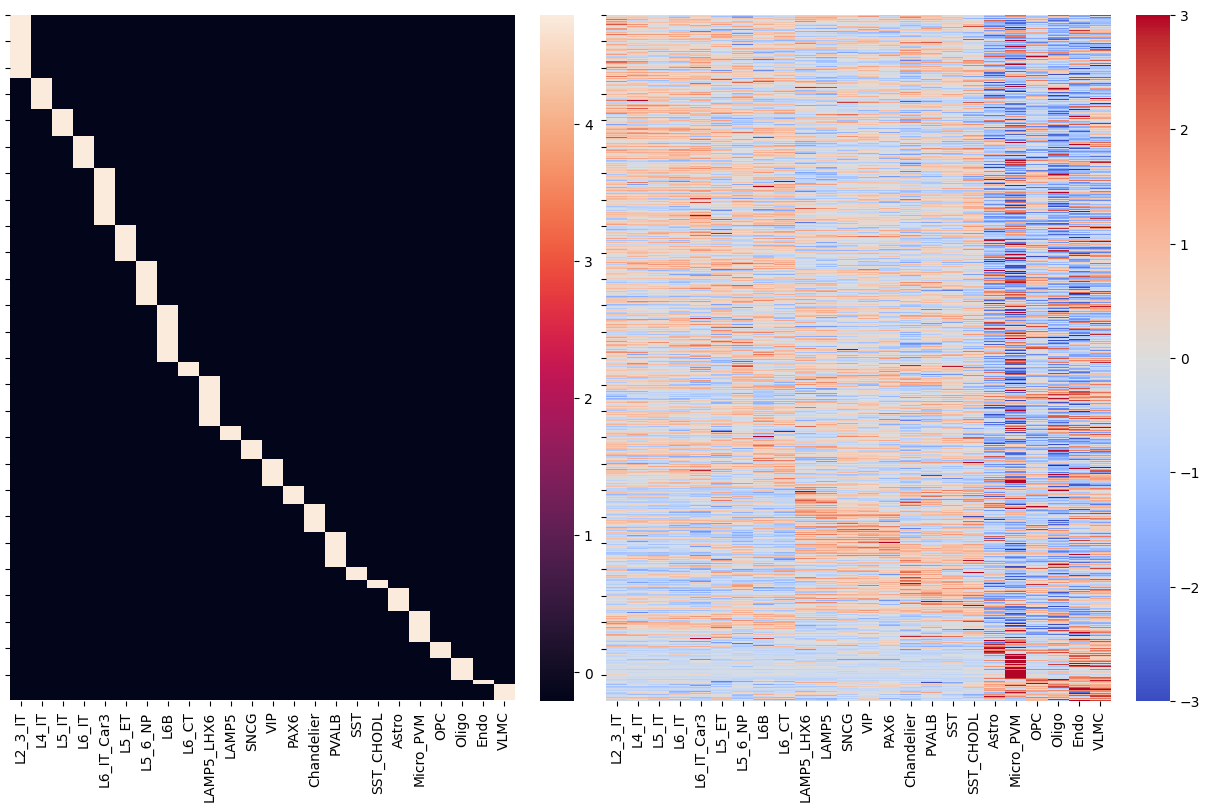

In [55]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(
    BICCN_marker_atac_cov_df.loc[sort_table["barcode"].to_list(), class_order],
    ax=ax1
)
ax1.set_yticklabels([]);
ax1.set_xticks(np.arange(len(class_order)) + 0.5)
ax1.set_xticklabels(class_order)
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(
    BICCN_gene_expr_df.loc[BICCN_marker_gene_df["Gene"], :], 
    ax=ax2, vmin=-3, vmax=3, cmap="coolwarm", center=0)
ax2.set_yticklabels([]);
ax2.set_xticks(np.arange(len(class_order)) + 0.5)
ax2.set_xticklabels(class_order)

fig.set_figheight(8)
fig.set_figwidth(12)